Requires WebbPSF version 7.0 and later

In [1]:
#stdlib
import os
import re
from collections import OrderedDict
import datetime

#Third Party
from astropy.io import fits
from astropy.table import Table
import astropy.units as u
import getpass
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import poppy
from scipy.io import loadmat
from scipy.optimize import curve_fit
from webbpsf import constants

# Local
import grab_opd_info


plt.rcParams.update({'figure.dpi' : 100,
                     'font.size' : 12,
                     'image.origin' : 'lower',
                     'image.interpolation' : 'nearest'})

%matplotlib inline

# Retreive Hexike Coefficients for Global Focus and Segment fits 

In [2]:
class Opd(object):
    def __init__(self, opd_data_str, npix=1024):
        self.npix = npix 
        
        self.opd, self.labeldict, _, self.newcentroids, self.segradius = grab_opd_info.grab_opd_info(opd_data_str, 
                                                                                                     npix=self.npix)
        self.units = u.micrometer

    
    def define_rho_theta(self, centroid, norm_radius):
        '''
        Define the rho and theta parameters that describe the aperture
        (segment or full OTE)
        '''
        x = (np.arange(self.npix, dtype=np.float64) - centroid[1]) / norm_radius
        y = (np.arange(self.npix, dtype=np.float64) - centroid[0]) / norm_radius
        xx, yy = np.meshgrid(x, y)
        rho = np.sqrt(xx ** 2 + yy ** 2)
        theta = np.arctan2(yy, xx)
        return rho, theta
    
    
    
        
    
    def fit_terms_to_surface(self, aperture, nterms, ap_centroid, ap_radius, 
                             iterations=15, terms_remove=None):
        '''
        Fit WSS Hexikes to a defined surface
        '''
        def get_basis(*args, **kwargs):
            return basis
        rho, theta = self.define_rho_theta(ap_centroid, ap_radius)
        basis = poppy.zernike.hexike_basis_wss(nterms=nterms, npix=self.npix, rho=rho,
                                               theta=theta, aperture=aperture > 0.)
        coeffs = poppy.zernike.opd_expand_nonorthonormal(self.opd, 
                                                         aperture=aperture > 0., 
                                                         nterms=nterms, 
                                                         basis=get_basis,
                                                         iterations=iterations)
        if terms_remove:
            self.new_coeffs = np.zeros_like(coeffs)
            for i in range(len(self.new_coeffs)):
                if i not in terms_remove:
                    self.new_coeffs[i] = coeffs[i]
        else:
            self.new_coeffs = coeffs

        
    def fit_terms_to_segments(self, aperture, nterms, ap_centroid, ap_radius, 
                              iterations=15):
        '''
        Fit WSS Hexikes to a segment
        '''
        def get_basis(*args, **kwargs):
            return basis

        rho, theta = self.define_rho_theta(ap_centroid, ap_radius)
        basis = poppy.zernike.hexike_basis_wss(nterms=nterms, npix=self.npix, rho=rho,
                                               theta=theta, aperture=aperture > 0.)
        coeffs = poppy.zernike.opd_expand_segments(self.opd,
                                                   aperture=aperture > 0., 
                                                   nterms=nterms, 
                                                   basis=get_basis, iterations=iterations)
        self.new_coeffs = coeffs

        
    def reconstruct_from_hexikes(self, aperture, nterms, ap_centroid, ap_radius):
        '''
        Reconstruct surface from Hexikes
        '''
        def get_basis(*args, **kwargs):
            return basis
        rho, theta = self.define_rho_theta(ap_centroid, ap_radius)
        basis = poppy.zernike.hexike_basis_wss(nterms=nterms, npix=self.npix, rho=rho,
                                               theta=theta, aperture=aperture > 0.)
        self.reconstructed = poppy.zernike.opd_from_zernikes(self.new_coeffs, 
                                                             basis=get_basis, 
                                                             aperture=aperture > 0.)
        self.reconstructed[~np.isfinite(self.reconstructed)] = 0.0

        

def rms(diff, mask):
    """
    Find the root mean square for a difference within a mask
    """
    return np.sqrt(np.mean(np.square(diff[mask != 0])))


In [3]:
def date_str_to_time(date_str):
    time = date_str.split('_')[0]
    num = time[3:]
    unit = time[:3]
    if len(num)>3:
        unit = num[-3:]
        num = num[:-3]
        
    return "{} {}".format(num, unit)

In [4]:
# global variables
try:
    segids = constants.SEGNAMES # segment names
except AttributeError:
    segids = [s[0][:2] for s in constants.JWST_PRIMARY_SEGMENT_CENTERS]

ref_ap_diam = constants.JWST_CIRCUMSCRIBED_DIAMETER 

pixscale = 0.006526714427860697
nterms = 9

opd_units = u.micrometer

In [5]:
dates = grab_opd_info.grab_dates_from_mat()

In [6]:
print(dates)

['day10000sec_data', 'day1_data', 'day7_data', 'day14_data', 'day30_data']


## Fit Global Focus 
For a given OPD, first fit global focus

In [7]:
opd_data_str = dates[0]
opd_global = Opd(opd_data_str=opd_data_str)

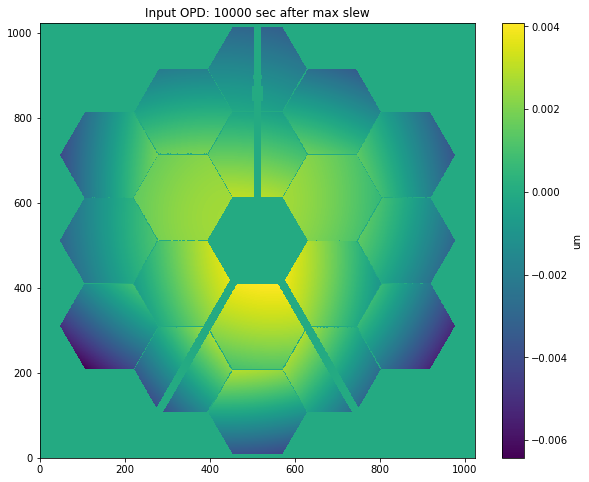

In [8]:
plt.figure(figsize=(10, 8))
plt.imshow(opd_global.opd)
plt.title("Input OPD: {} after max slew".format(date_str_to_time(opd_data_str)))
cbar = plt.colorbar()
cbar.set_label('{}'.format(opd_units))
plt.show()

In [9]:
# Fit focus to full OTE
full_aperture = opd_global.opd != 0  # Full aperture mask (1.0s where the mirrors are)
ref_ap_radius = ref_ap_diam//pixscale/2  # Find the radius of the OTE

# Fit Hexike terms to the surface as described by the variables above
opd_global.fit_terms_to_surface(full_aperture, nterms=5, 
                                ap_centroid=(opd_global.npix//2,opd_global.npix//2), 
                                ap_radius=ref_ap_radius, terms_remove=[0,1,2,3]) 

#Reconstruct the surface using those measured Hexikes
opd_global.reconstruct_from_hexikes(full_aperture, nterms=5, 
                                     ap_centroid=(opd_global.npix//2,opd_global.npix//2), 
                                     ap_radius=ref_ap_radius)

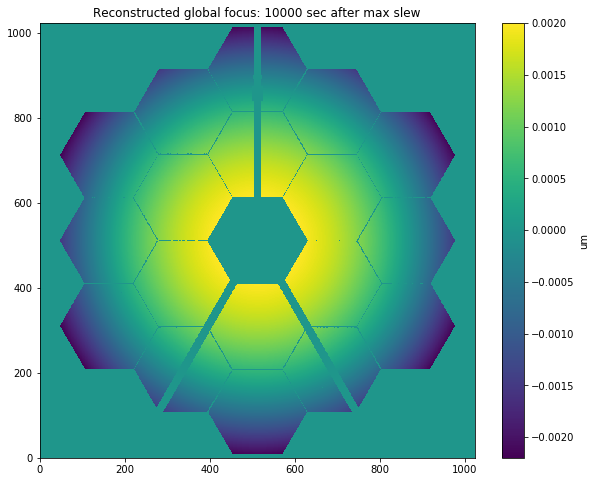

In [10]:
plt.figure(figsize=(10, 8))
plt.imshow(opd_global.reconstructed)
plt.title("Reconstructed global focus: {} after max slew".format(date_str_to_time(opd_data_str)))
cbar = plt.colorbar()
cbar.set_label('{}'.format(opd_units))
plt.show()

In [11]:
global_rms = rms(opd_global.opd, full_aperture)
opd_focus_sub = opd_global.opd - opd_global.reconstructed

## Fit Hexikes to each segment

In [12]:
# Create new Opd object with the starting OPD the focus subtracted OPD from above
opd_segs = Opd(opd_data_str=opd_data_str) #Create the same OPD first to get labeldict parameters and such
opd_segs.opd = opd_focus_sub

In [13]:
plot = False

In [14]:
# Fit Hexikes to all segments
rmses = []
coeffs = []
reconstructed_opd = np.zeros_like(opd_segs.opd)
for segid in segids:
#     opd_segs.fit_terms_to_surface(opd_segs.labeldict[segid], nterms, opd_segs.newcentroids[segid], 
#                               opd_segs.segradius)
    opd_segs.fit_terms_to_segments(opd_segs.labeldict[segid], nterms, opd_segs.newcentroids[segid], 
                               opd_segs.segradius, iterations=15)
    opd_segs.reconstruct_from_hexikes(opd_segs.labeldict[segid], nterms, opd_segs.newcentroids[segid], 
                                   opd_segs.segradius)
    if plot: 
        fig, axes = plt.subplots(1, 3, figsize = (15, 15))
        axes[0].imshow(opd_segs.opd)
        axes[0].set_title('Full OPD')
        axes[1].imshow(opd_segs.reconstructed)
        axes[1].set_title('Segments Reconstruction')
        axes[2].imshow(opd_segs.opd - opd_segs.reconstructed, norm=im.norm)
        axes[2].set_title('Hexike Content Removed')
        plt.show()
    
    reconstructed_opd += opd_segs.reconstructed
    coeffs.extend(opd_segs.new_coeffs)
    
    # Find the rms difference between the reconstructed segment and the original
    diff = opd_segs.opd - opd_segs.reconstructed
    rmses.append(rms(diff, opd_segs.labeldict[segid]))

#### There seems to be a disagreement on deconstruction of segments with struts in the way between `opd_expend_orthonormal` and `opd_expand_segments` the former seems to do it correctly while there are larger residuals with the latter

`coeffs` and `rmses` are flat lists of the coefficients and rms values for each segment. This is probably not idea... but at least predictable.

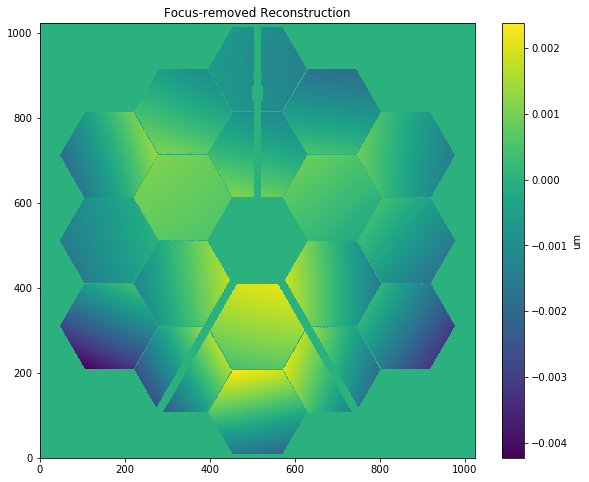

In [15]:
plt.figure(figsize=(10, 8))
plt.imshow(reconstructed_opd)
plt.title("Focus-removed Reconstruction".format(date_str_to_time(opd_data_str)))
cbar = plt.colorbar()
cbar.set_label('{}'.format(opd_units))
plt.show()

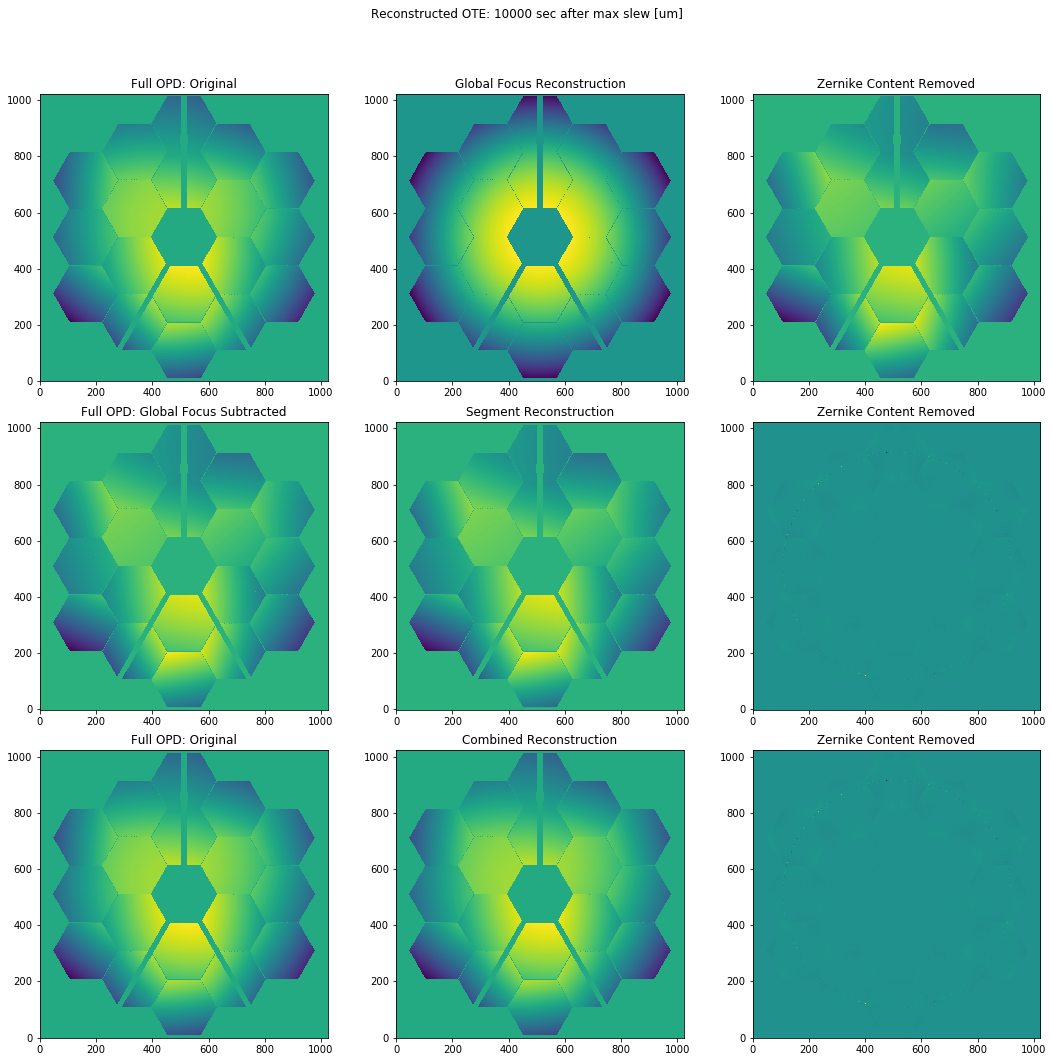

In [16]:
plt.figure()
fig, axes = plt.subplots(3, 3, figsize = (15, 15))
axes[0,0].imshow(opd_global.opd)
axes[0,0].set_title('Full OPD: Original')
axes[0,1].imshow(opd_global.reconstructed)
axes[0,1].set_title('Global Focus Reconstruction')
axes[0,2].imshow(opd_focus_sub )
axes[0,2].set_title('Zernike Content Removed')

axes[1,0].imshow(opd_segs.opd)
axes[1,0].set_title('Full OPD: Global Focus Subtracted')
axes[1,1].imshow(reconstructed_opd)
axes[1,1].set_title('Segment Reconstruction')
axes[1,2].imshow(opd_segs.opd - reconstructed_opd)#, norm=im.norm)
axes[1,2].set_title('Zernike Content Removed')

# Add global fit and segment fits and subtract from original
axes[2,0].imshow(opd_global.opd)
axes[2,0].set_title('Full OPD: Original')
axes[2,1].imshow(reconstructed_opd+opd_global.reconstructed)
axes[2,1].set_title('Combined Reconstruction')
axes[2,2].imshow(opd_global.opd - (reconstructed_opd+opd_global.reconstructed))
axes[2,2].set_title('Zernike Content Removed')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle("Reconstructed OTE: {} after max slew [{}]".format(date_str_to_time(opd_data_str), opd_units))
plt.show()


In [17]:
print("RMS of residuals of global focus fit")
print("RMS: {} {}".format(rms(opd_global.opd - opd_global.reconstructed, full_aperture), opd_units))
print(" ")
print("RMS of residuals of fits to segments")
print("RMS: {} {}".format(rms(opd_segs.opd - reconstructed_opd, full_aperture), opd_units))
print(" ")
print("RMS of residuals of combined fit")
print("RMS: {} {}".format(rms(opd_global.opd - (reconstructed_opd + opd_global.reconstructed), full_aperture), opd_units))

RMS of residuals of global focus fit
RMS: 0.0010483020355693538 um
 
RMS of residuals of fits to segments
RMS: 1.5056056215744174e-07 um
 
RMS of residuals of combined fit
RMS: 1.505605621574417e-07 um


Now that we see that this works, we can optimize this and apply to all dates so that we have Hexike coefficients for all segments (+SM)

# Complete for all dates 

In [18]:
def coeffs_from_opds(opd_data_str, npix=1024, plot=False):
    """
    Deconstruct the OPD into it's global focus and then decronstruct the individual segments 
    into the different Hexikes
    
    Returns: opds, rmses, coeffs
    """
    rmses = []
    coeffs = []
    opds = {}
    
    ## Fit global terms
    opd_global = Opd(opd_data_str, npix)
    # Fit focus to full OTE
    full_aperture = sum(opd_global.labeldict[segid] for segid in segids)
    ref_ap_radius = ref_ap_diam//pixscale/2
    nterms_global = 5

    opd_global.fit_terms_to_surface(full_aperture, nterms_global, (opd_global.npix//2, opd_global.npix//2), 
                              ref_ap_radius, terms_remove=[0,1,2,3])
    
    # Add coefficient and RMS value to lists
    opds["SM"] = {}
    opds["SM"]["coeffs"] = float(opd_global.new_coeffs[opd_global.new_coeffs!=0.0])
    opds["SM"]["rms"] = rms(opd_global.opd, full_aperture)
    coeffs.append(float(opd_global.new_coeffs[opd_global.new_coeffs!=0.0])) #Pull out the non-zero value
    rmses.append(rms(opd_global.opd, full_aperture))
    
    opd_global.reconstruct_from_hexikes(full_aperture, 5, (opd_global.npix//2, opd_global.npix//2), ref_ap_radius)

    # Create new Opd object 
    opd_segs = Opd(opd_data_str) #Create the same OPD first to get labeldict parameters and such
    opd_segs.opd = opd_global.opd - opd_global.reconstructed #Replace OPD with the focus-subtracted OPD
    
    ## Fit Hexikes to all segments
    reconstructed_opd = np.zeros_like(opd_segs.opd)
    for segid in segids:
        opds[segid] = {}
        opd_segs.fit_terms_to_segments(opd_segs.labeldict[segid], nterms, opd_segs.newcentroids[segid], 
                                  opd_segs.segradius, iterations=10)
        opd_segs.reconstruct_from_hexikes(opd_segs.labeldict[segid], nterms, opd_segs.newcentroids[segid], 
                                        opd_segs.segradius)
        reconstructed_opd += opd_segs.reconstructed
        
        # Find the rms difference between the reconstructed segment and the original
        diff = opd_segs.opd - opd_segs.reconstructed
        
        opds[segid] = {}
        opds[segid]["coeffs"] = opd_segs.new_coeffs
        opds[segid]["rms"] = rms(diff, opd_segs.labeldict[segid])
        coeffs.extend(opd_segs.new_coeffs)
        rmses.append(rms(diff, opd_segs.labeldict[segid]))

    if plot:
        print("Plots normalized to original OPD")
        fig, ax = plt.subplots(1, 3, figsize=(15,5))
        im = ax[0].imshow(opd_global.opd)
        ax[0].set_title('Full OPD: Original')
        ax[1].imshow(opd_global.reconstructed+reconstructed_opd, norm=im.norm)
        ax[1].set_title('Reconstruction')
        ax[2].imshow(opd_global.opd - (opd_global.reconstructed+reconstructed_opd), norm=im.norm)
        ax[2].set_title('Hexike Content Removed, RMS: {:.3e} {}'.format(rms(opd_global.opd - (opd_global.reconstructed+reconstructed_opd), 
                                                                      opd_global.opd != 0), opd_global.units))
        plt.suptitle("{}s since max slew".format(date_str_to_time(opd_data_str)))
        plt.show()
    return opds, coeffs, rmses

In [19]:
def retrieve_time_from_date(dates):
    '''
    Convert dates strings to times in days
    
    Parameters
    ==========
    dates: list of strs
    '''
    secs = [s for s in dates if 'sec' in s]
    days = set(dates) ^ set(secs)
    times_sec = [int(re.findall('\d+', d)[0]) for d in secs]
    times_day = [int(re.findall('\d+', d)[0]) for d in days]
    sec2day = 1./86400.
    times_sec = [y*sec2day for y in times_sec]

    return sorted(times_sec + times_day)

###  Start by decomposing global focus, subtracitng fit from original OPD, and then decomposing segments 

Plots normalized to original OPD


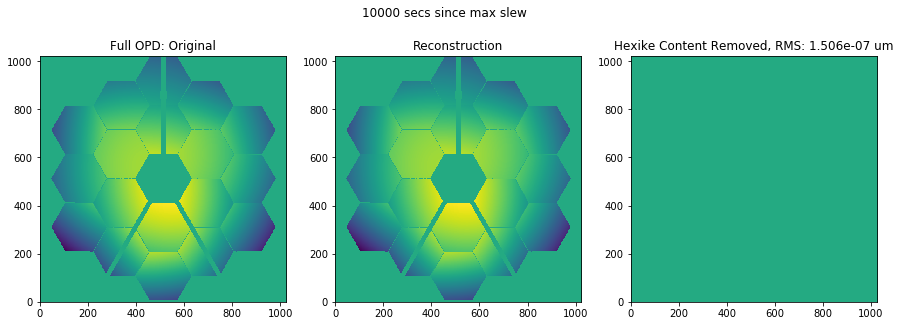

Plots normalized to original OPD


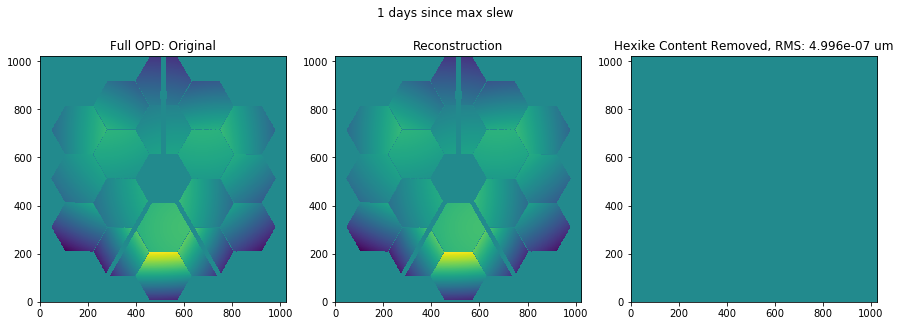

Plots normalized to original OPD


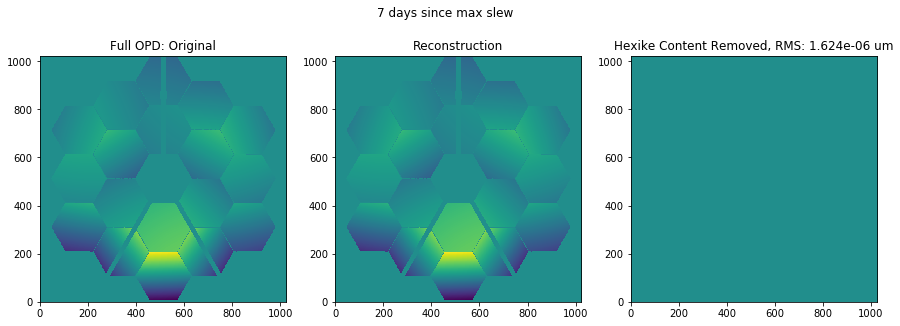

Plots normalized to original OPD


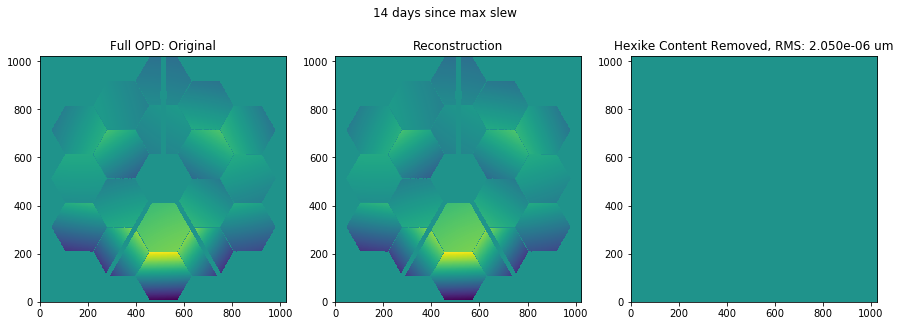

Plots normalized to original OPD


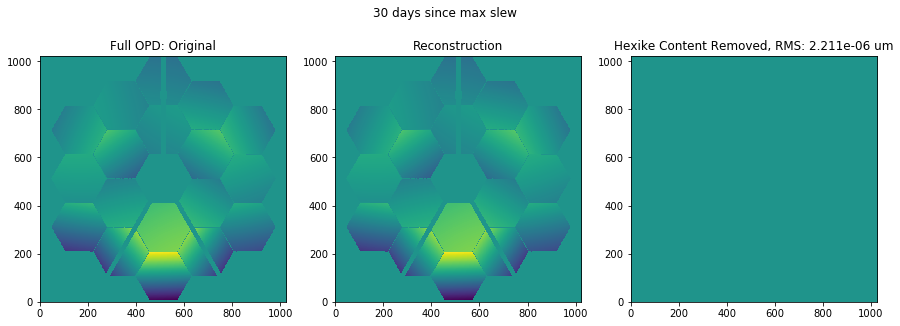

In [20]:
allopds = {}
coeff_data = []
for date in dates:
    allopds[date], coeffs, _ = coeffs_from_opds(date, plot=True)
    coeff_data.append(coeffs)

coeff_data = np.squeeze(np.asarray(coeff_data))

In [21]:
# Update segid list to include SM
allsegids = list(segids)
allsegids.append("SM")

### Create lists that match coefficents with their segment and coefficient number

In [22]:
# Create a list of segments names that matches the list of coeffs (only works for `coeff_data`)
seglist = ["SM"]
seglist.extend([y for x in segids for y in [x] * nterms])
seglist = np.squeeze(seglist)

In [23]:
# Create a list of h numbers that matches the list of coeffs (only works for `coeff_data`)
hlist = [5]
hlist.extend([x+1 for x in range(nterms)]*len(segids))
hlist = np.squeeze(hlist)

## Fit 2nd order thermal response function

We have discovered during testing that there is behavior in the first three time points that indicate that a first order thermal response function is not sufficient in fitting the data. This implies that time-dependent variations due to maximum slew relative to the sun causes responses in the primary mirror segments that operate on two different time scales. 

$$y(x)=A_{1}e^{−xt_{1}}+A_{2}e^{−xt_{2}}$$

In [24]:
def second_order_thermal_response_function(x, tau_1, gn_1, tau_2, gn_2):
    '''
    Second order thermal response function
    '''
    return gn_1*(1-np.exp(-1*(x/tau_1))) + gn_2*(1-np.exp(-1*(x/tau_2)))
    

In [25]:
def fit_curve_per_coeff(times, coeffs):
    '''
    For a  Zernike/Hexike term in time for each segment, fit a curve to 
    the coeffcients in order to extrapolate the fitting parameters
    '''
    # Add bounds to the curve so that the fits will converge
    params, cov = curve_fit(second_order_thermal_response_function, times, 
                            coeffs, bounds=([0., -1*np.inf, 5., -1*np.inf],
                                            [5., np.inf, 1000., np.inf]))
    uncertainty = np.sqrt(np.diag(cov))
    tau_1, gn_1, tau_2, gn_2 = params
    return tau_1, gn_1, tau_2, gn_2, uncertainty

In [26]:
xdata = retrieve_time_from_date(dates)

In [27]:
taus_1 = []
gns_1 = []
taus_2 = []
gns_2 = []
uncertainties_1 = []
shape = np.shape(coeff_data)
for i in range(shape[1]):
    tau_1, gn_1, tau_2, gn_2, u = fit_curve_per_coeff(xdata, coeff_data[:,i])
    taus_1.append(tau_1)
    gns_1.append(gn_1)
    taus_2.append(tau_2)
    gns_2.append(gn_2)
    uncertainties_1.append(u)

In [28]:
hexike_labels = poppy.zernike.hexike_basis_wss.label_strings

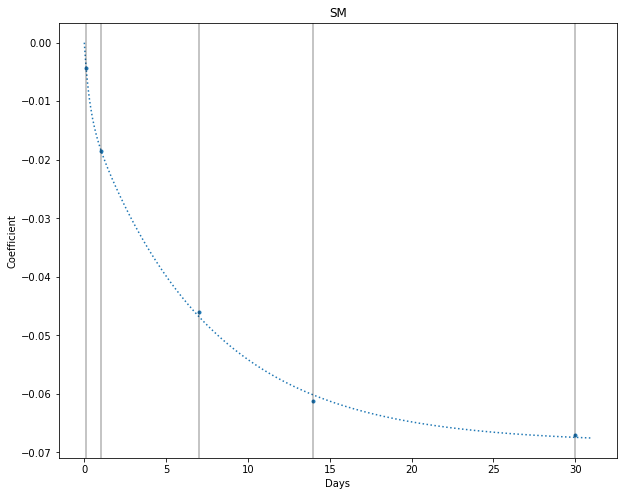

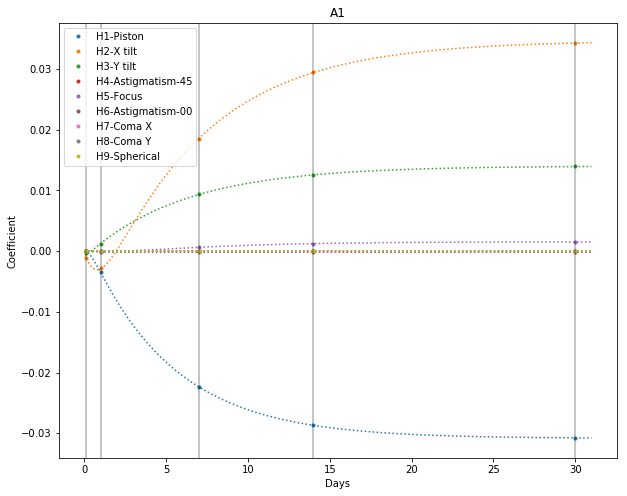

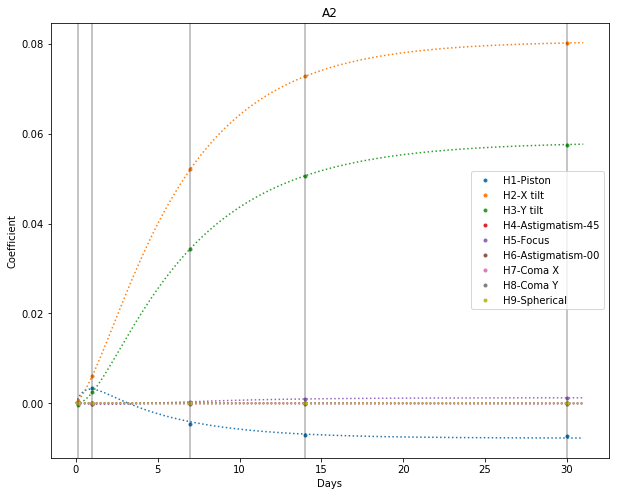

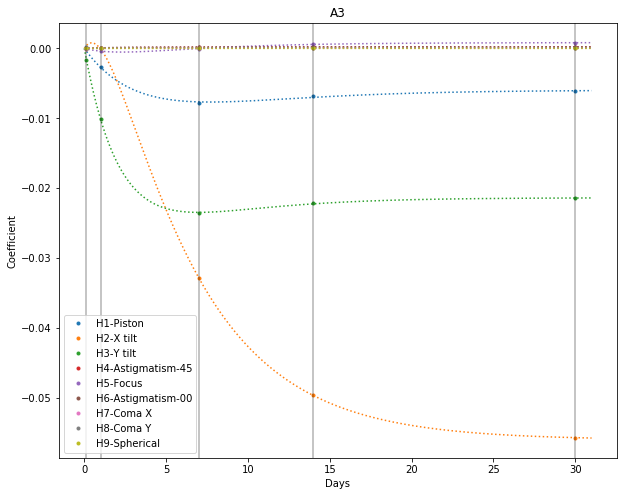

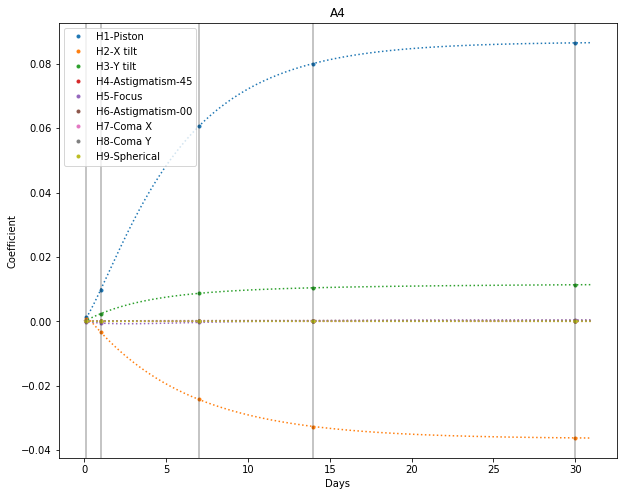

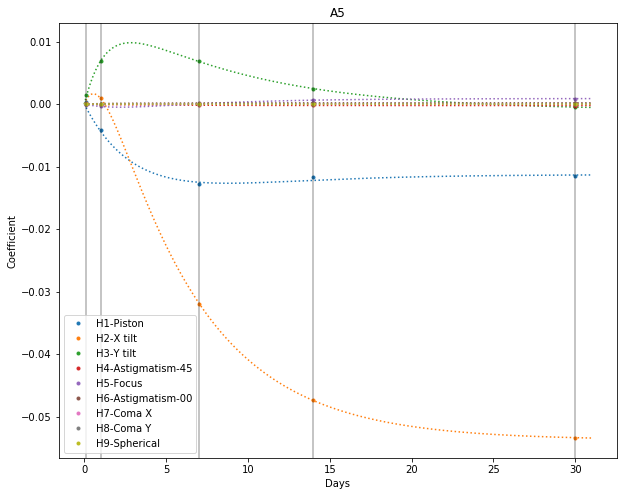

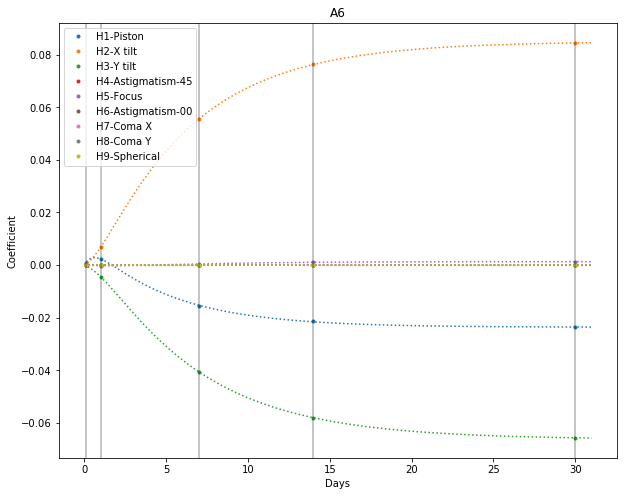

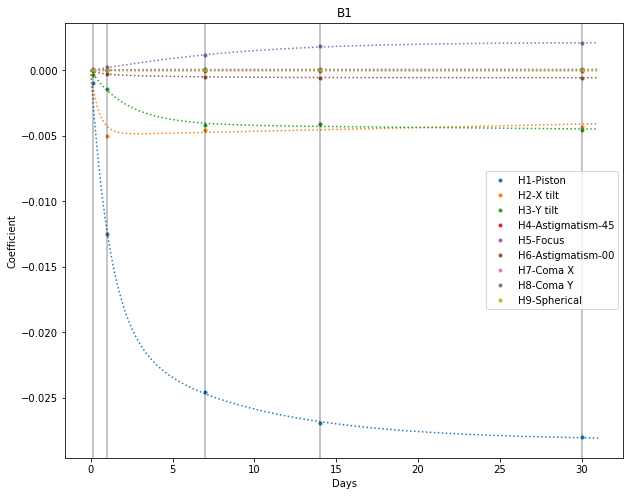

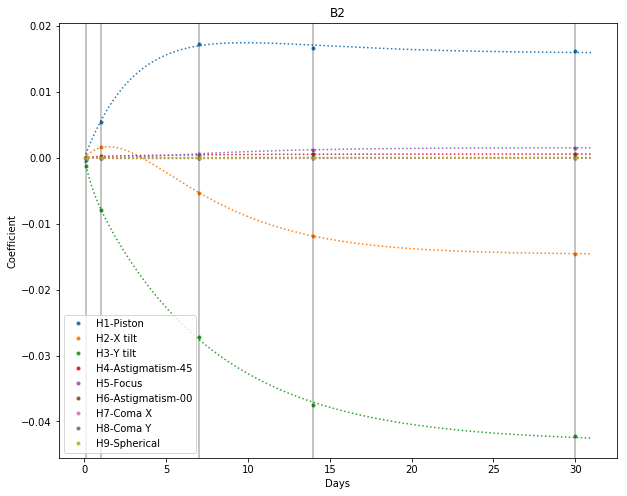

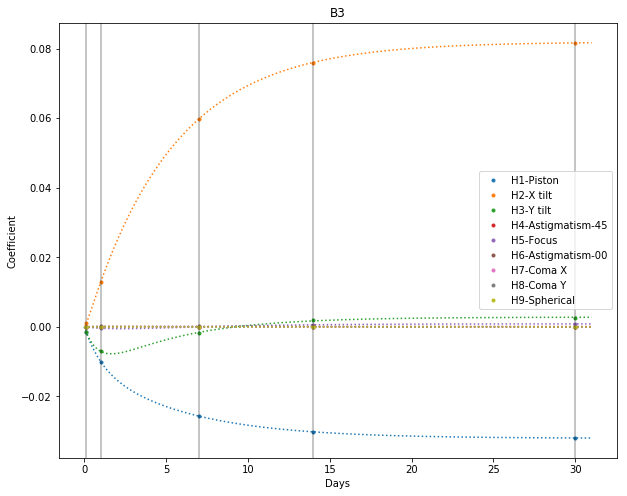

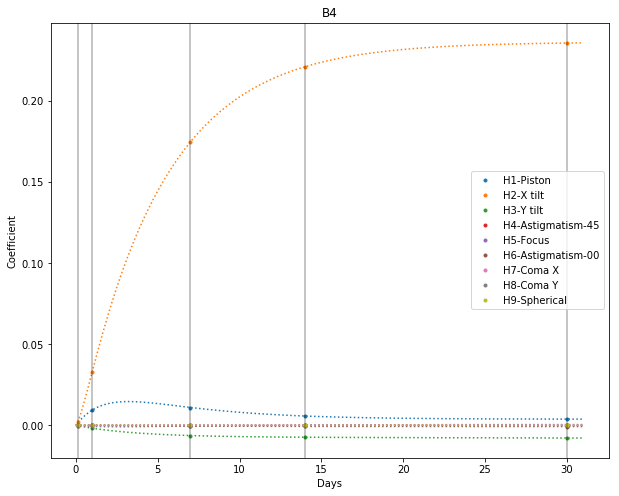

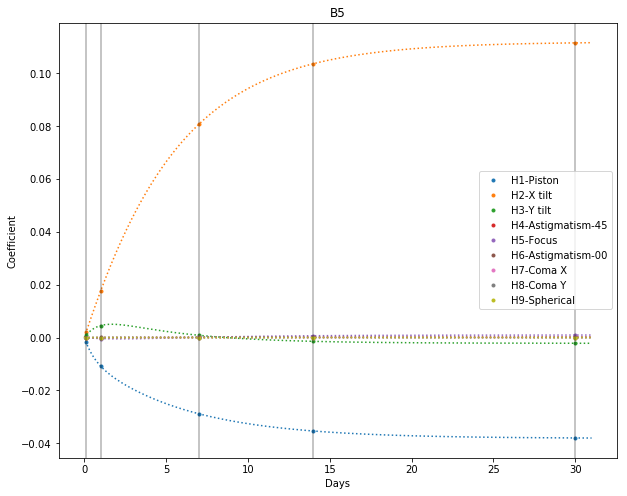

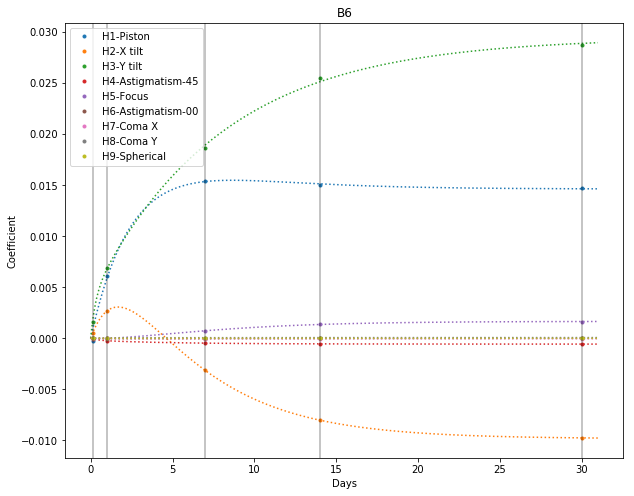

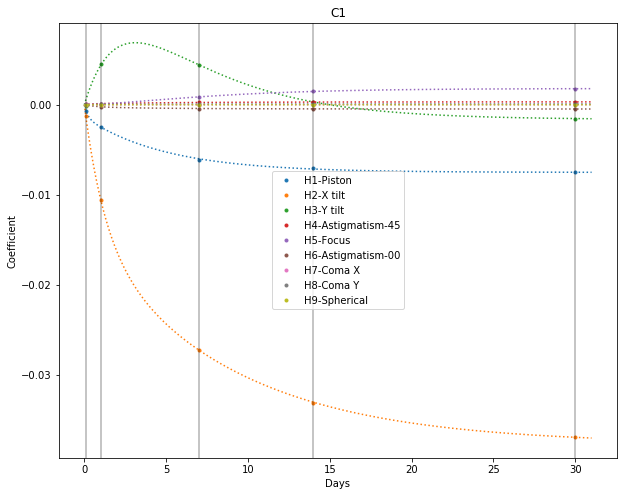

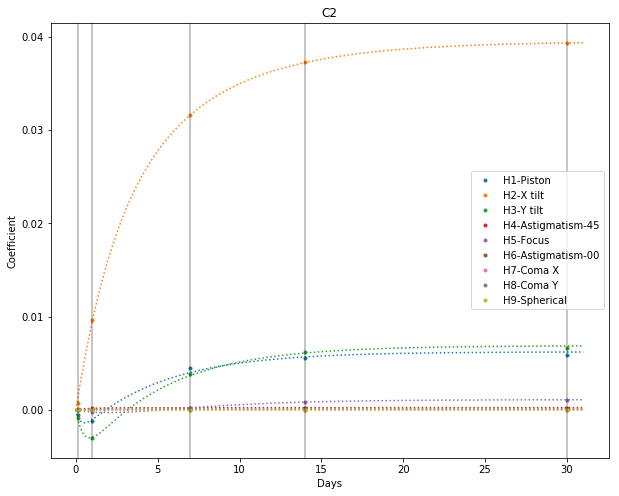

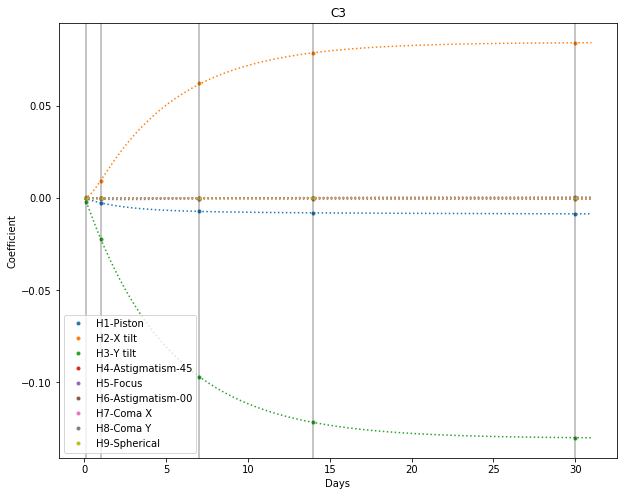

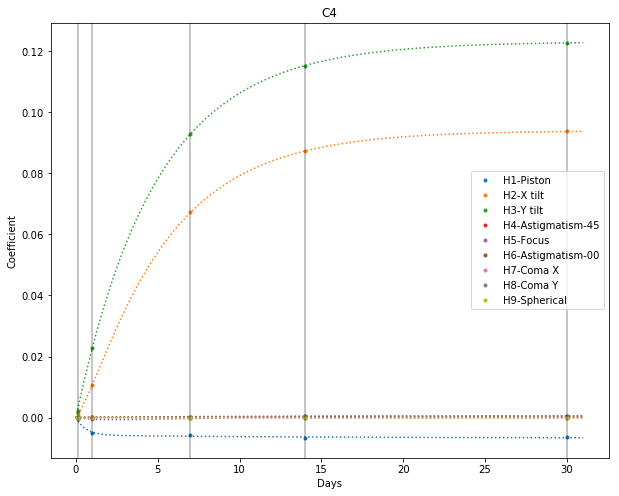

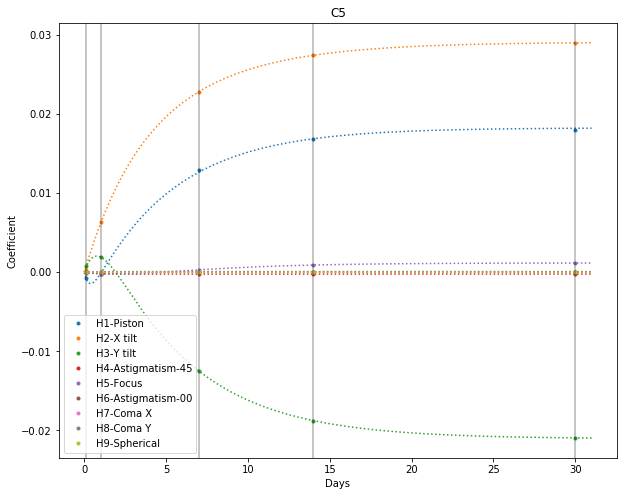

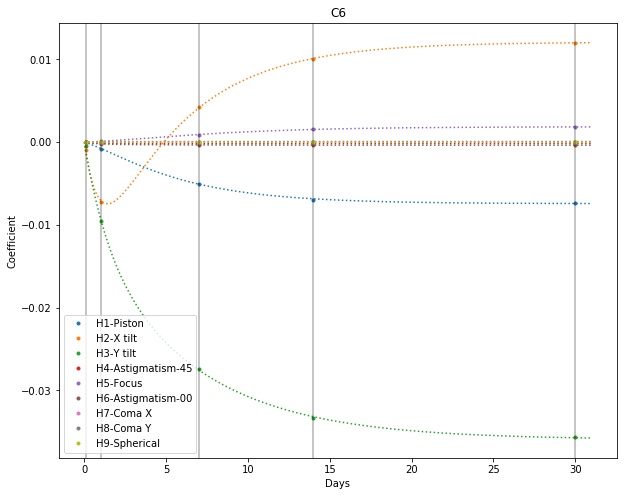

In [29]:
# Data with global focus MEASURED coeffs data
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
x = np.linspace(0, 31, 500)

# Plot out SM
plt.figure(figsize = (10, 8))
y = (second_order_thermal_response_function(x, taus_1[0], gns_1[0], taus_2[0], gns_2[0]))
plt.plot(xdata, coeff_data[:,0], '.', color=colors[0])
plt.plot(x, y, ':', color=colors[0], label='2nd Order Thermal Reponse')
for xd in xdata:
    plt.axvline(xd, color='black', alpha=0.3)
plt.title('SM')
plt.xlabel('Days')
plt.ylabel('Coefficient')
plt.show()


for seg in range(18):
    plt.figure(figsize = (10, 8))
    for i in range(nterms):
        plt.plot(xdata, coeff_data[:,i+seg*9+1], '.', color=colors[i], label='H{}-{}'.format(hlist[i+seg*9+1], 
                                                                                             hexike_labels[i]))
        y = (second_order_thermal_response_function(x, taus_1[i+seg*9+1], gns_1[i+seg*9+1], taus_2[i+seg*9+1], 
                                                     gns_2[i+seg*9+1]))
        plt.plot(x, y, ':', color=colors[i])
    for xd in xdata:
        plt.axvline(xd, color='black', alpha=0.3)
    plt.title(seglist[seg*9+1])
    plt.legend()
    plt.xlabel('Days')
    plt.ylabel('Coefficient')
    plt.show()

### Build the `FITS` dictionary 

In [30]:
def test_key(dictionary, key, list=True):
    """
    Test the key in a diction and if it does not exist, create it
    """
    try:
        dictionary[key]
    except KeyError:
        dictionary[key] = {}
        if list:
            dictionary[key] = []
            
def build_fits_dict(dictionary, keys, values):
    '''
    Create the allsegs dictionary for the fit parameters
    
    Parameters
    ==========
    dictionary: dict
        Dictionary where these items will be added
    keys: list of strs
        List of the key names
    values: list of floats
        List of the key values
    '''
    for key, value in zip(keys, values):
        test_key(dictionary, key)
        dictionary[key].append(value)
    
    return dictionary

In [31]:
keys = ['segs', 'Hs', 'Gn1', 'err Gn1', 'tau1', 'err tau1', 'Gn2', 'err Gn2', 'tau2', 'err tau2']

In [32]:
allsegs = OrderedDict()
for i in range(shape[1]):
    values = [seglist[i], hlist[i], gns_1[i], uncertainties_1[i][0], taus_1[i], uncertainties_1[i][1], 
              gns_2[i], uncertainties_1[i][2], taus_2[i], uncertainties_1[i][3]]
    allsegs = build_fits_dict(allsegs, keys, values)

In [33]:
col_names = ["COL{}".format(i+1) for i in range(len(keys))]
comments = ['Name of the segment', 
            'Hexike Number', 
            'Gain 1 of the fitting function', 
            'Uncertainty of the G_n1 value based on fit',
            'Time constant 1 (Tau) of the fitting function',
            'Uncertainty of the tau1 value based on fit',
            'Gain 2 of the fitting function',     
            'Uncertainty of the G_n2 value based on fit',     
            'Time constant 2 (Tau) of the fitting function', 
            'Uncertainty of the tau2 value based on fit']

col_meta = []
for (col, ke, com) in zip(col_names, keys, comments):
    col_meta.append((col, ke, com))

In [34]:
col_meta.append(('GUNIT', str(opd_units), 'Units of the G_n term'))
col_meta.append(('TUNIT', str(opd_units), 'Units of the Tau term'))
col_meta.append(('FUNC', "y(x) = Gn1*exp[-x*tau1] + Gn2*exp[-x*tau2]", "fitting function"))

Turn build_meta_data into all tuples??

In [54]:
def build_header(fits_obj):
#     header = fits.Header()
    fits_obj.header["CREATOR"] = (getpass.getuser().capitalize(), "File creator")
    fits_obj.header["DATE"] = (datetime.datetime.today().strftime('%Y-%m-%d'), 'Date created') 
    fits_obj.header["NB"] = ("Fit Time-Variant Thermal OPDs.ipynb",
                    'Notebook used to create this file')
    fits_obj.header["NBAUTHOR"] = ("K. Brooks", "notebook author")
    fits_obj.header["BUNIT"] = (str(opd_units), 'Units of the OPD')
    fits_obj.header["HISTORY"] = "These fitting parameters were created from thermal OPDs models spanning"
    fits_obj.header["HISTORY"] = "five time steps between 10ks and 30days, provided by J. Scott Knight. " 
    fits_obj.header["HISTORY"] = "Original OPDs included in: JWST_thermal_response_data05_31_2017.mat"
    fits_obj.header["HISTORY"] = "This file can be parsed with grab_opd_info.py"
    
    # Append meta data regarding columns and equation used
#     for m in col_meta:
#         header.append(m)
    
    for i, h in enumerate(hexike_labels):
        fits_obj.header["H{}".format(i+1)] = ('Hexike = {}'.format(i+1), "{}".format(h))
    
    return fits_obj

In [49]:
# meta = build_meta_data(col_meta)
# for (k, v) in zip(meta.keys(), meta.values()):
#     print(v)

BOOOO I lose all my comments


In [50]:
def dict_to_fits(dictionary, outfile):
    ''' Write dictionary to Fits bin table'''
    tab = Table(dictionary) 
    hdu = fits.table_to_hdu(tab)
    hdu = build_header(hdu)
    print(hdu.header)
    hdu.writeto('{}'.format(outfile), overwrite=True)

In [51]:
target_dir = '/Users/kbrooks/Documents/tel/CWG/itar/Ball/'
out_file = os.path.join(target_dir,'thermal_OPD_fitting_parameters_{}H_{}.fits'.format(nterms, opd_units))
dict_to_fits(allsegs, out_file)
print("Saved to {}".format(out_file))

XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                   74 / length of dimension 1                          NAXIS2  =                  163 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                   10 / number of table fields                         TTYPE1  = 'segs    '                                                            TFORM1  = '2A      '                                                            TTYPE2  = 'Hs      '                                                            TFORM2  = 'K       '                                                            TTYPE3  = 'Gn1     '                    